In [1]:
from adnmtf import NMF, NTF
# from sklearn.decomposition import NMF
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import matplotlib.image as image
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import distinctipy
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import sys
import networkx as nx
from sklearn.preprocessing import normalize
from sklearn import metrics

from mvlearn.datasets import load_UCImultifeature
from mvlearn.embed import MVMDS
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
# from umap import umap_
from scipy.spatial import distance_matrix
import hoggorm as ho
import tensorly as tl
from tensorly.decomposition import non_negative_parafac_hals

from sklearn.metrics.cluster import rand_score
from sklearn.preprocessing import StandardScaler
from mofapy2.run.entry_point import entry_point

RESULTS_PATH = r'C:\Users\paul_\OneDrive\Pro\George\Wise\analysis\results\abis'

list_solutions = None
predefined_solution = ''

#  ISM algorithmic options
embed = True
max_iter_integrate = 20
update_h4_ism = True

# Grid search limits
min_embedding = 10
max_embedding = 25
min_themes = 16
max_themes = 16

# list_solutions contains one ore more solutions selected because of their low condition numbers
list_solutions = [[16,16]]


In [2]:
# GFA wrapper
"""
GFA (Group Factor Analysis)
This is a Python implementation of the file ./R/CCAGFA.R in the R package CCAGFA
https://github.com/mladv15/gfa-python
"""

from __future__ import division, print_function
import numpy as np
import scipy as sp
import scipy.special
import scipy.linalg
import scipy.optimize
import math
import matplotlib.pyplot as plt
def gfa_experiments(Y, K, Nrep=10, verbose=1, **opts):
    """
    A wrapper for running the GFA model `Nrep` times
    and choosing the final model based on the best
    lower bound. This is the recommended way of applying
    the algorithm.
    See GFA() for description of the inupts.
    """
    opts["verbose"] = verbose
    lb = []  # lower bounds
    models = []  # the best one will be returned
    for rep in range(Nrep):
        model = gfa(Y, K, R=2, **opts)
        models.append(model)
        lb.append(model['cost'][-1])  # not defined yet
        if verbose == 1:
            # TODO: this is just a placeholder, will add real values after gfa() is finished
            print("Run %d/%d: %d iterations with final cost %f" % (rep+1, Nrep, len(model['cost']), lb[rep]))
    k = np.argmax(lb)
    return models[k]


def gfa(Y, K,
        R="full", lambda_=0.1, rotate=True,
        opt_method="L-BFGS", opt_iter=10e5, lbfgs_factr=10e10, bfgs_crit=10e-5,
        init_tau=1000,
        iter_crit=10e-6, iter_max=10e5,
        addednoise=1e-5,
        prior_alpha_0=1e-14, prior_alpha_0t=1e-14,
        prior_beta_0=1e-14, prior_beta_0t=1e-14,
        dropK=True, low_mem=False,
        verbose=2):
    """
    Parameters
    ----------
    Y : list
       List of M data ndarrays. Y[m] is an ndarray (matrix) with
       N rows (samples) and D_m columns (features). The
       samples need to be co-occurring.
       NOTE: All of these should be centered, so that the mean
             of each feature is zero
       NOTE: The algorithm is roughly invariant to the scale
             of the data, but extreme values should be avoided.
             Data with roughly unit variance or similar scale
             is recommended.
    K : int
        The number of components

    Returns
    -------
    The trained model, which is a dict that contains the following elements:
    TODO: (could make the model an object later)
        Z    : The mean of the latent variables; N times K matrix
        covZ : The covariance of the latent variables; K times K matrix
        ZZ   : The second moments ZZ^T; K times K matrix

        W    : List of the mean projections; D_i times K matrices
        covW : List of the covariances of the projections; D_i times D_i matrices
        WW   : List of the second moments WW^T; K times K matrices

        tau  : The mean precisions (inverse variance, so 1/tau gives the
            variances denoted by sigma in the paper); M-element vector

        alpha: The mean precisions of the projection weights, the
            variances of the ARD prior; M times K matrix

        U,V,u.mu,v.mu: The low-rank factorization of alpha.

        cost : Vector collecting the variational lower bounds for each
            iteration
        D    : Data dimensionalities; M-element vector
        datavar   : The total variance in the data sets, needed for
                 GFAtrim()
        addednoise: The level of extra noise as in opts$addednoise

    They use getDefaultOpts() in the R package,
    but I guess specifying default argument values like this is more standard Python,
    like scikit learn https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/gradient_boosting.py#L723.
    """
    # check that data is centered
    for m, Y_m in enumerate(Y):
        if not np.all(np.abs(np.mean(Y_m, axis=0)) < 1e-7) and verbose == 2:
            print("Warning: data from group %d does not have zero mean" % m)

    # check that there is more than one group of data
    if len(Y) < 2:
        print("Warning: the number of data sets must be larger than 1")

    # store dimensions
    M = len(Y)
    D = [Y_m.shape[1] for Y_m in Y]  # Data dimensions for each group. D = [D_1, ..., D_M]
    D = np.array(D)
    Ds = sum(D)                      # total nr of features
    N = Y[0].shape[0]                # total number of samples
    datavar = []                     # total variance of the data for each group
    for Y_m in Y:
        # Y_m is NxD_m, so take variance along column (axis=0), total variance <- sum
        datavar.append(sum(np.var(Y_m, axis=0)))

    if isinstance(R, int) and R >= min(M, K):
        if verbose == 2:
            print("The rank corresponds to full rank solution.")
        R = "full"
    if R != "full":
        if verbose == 2:
            print("NOTE: optimization of the rotation is not supported for low rank model")
        rotate = False

    # Some constants for speeding up the computation
    const = - N*Ds/2*np.log(2*np.pi)  # constant factors for the lower bound
    Yconst = [np.sum(np.vectorize(pow)(Y_m, 2)) for Y_m in Y]
    id_ = np.ones(K)
    alpha_0 = prior_alpha_0   # Easier access for hyperprior values
    beta_0 = prior_beta_0
    alpha_0t = prior_alpha_0t
    beta_0t = prior_beta_0t

    #
    # Initialize the model randomly; other initializations could
    # be done, but overdispersed random initialization is quite good.
    #

    # Latent variables Z
    Z = np.random.randn(N, K)   # The mean
    covZ = np.diag(np.ones(K))  # The covariance
    ZZ = covZ + covZ*N          # The second moments

    # ARD and noise parameters (What is ARD?)
    alpha = np.ones((M, K))     # The mean of the ARD precisions
    logalpha = np.ones((M, K))  # The mean of <\log alpha>
    if R == "full":
        b_ard = np.ones((M, K))     # The parameters of the Gamma distribution
        a_ard = alpha_0 + D/2       #       for ARD precisions
        # psi is digamma, derivative of the logarithm of the gamma function
        digammaa_ard = sp.special.psi(a_ard)
    tau = np.repeat(init_tau, M)    # The mean noise precisions
    a_tau = alpha_0t + N*D/2        # The parameters of the Gamma distribution
    b_tau = np.zeros(M)             #   for the noise precisions
    digammaa_tau = sp.special.psi(a_tau)  # Constants needed for computing the lower bound
    lgammaa_tau = -np.sum(np.vectorize(math.lgamma)(a_tau))
    lb_pt_const = -M*np.vectorize(math.lgamma)(alpha_0t) + M*alpha_0t*np.log(beta_0t)

    # Alpha needs to be initialized to match the data scale
    for m in range(M):
        alpha[m, :] = K*D[m]/(datavar[m]-1/tau[m])

    # The projections
    # No need to initialize projections randomly ,since their updating
    # step is the first one; just define the variables here
    #low_mem = True
    W = [None]*M  # the means
    if not low_mem:
        covW = [None]*M  # the covariances
    else: 
        covW = np.diag(np.ones(K))

    WW = [None]*M  # the second moments
    for m in range(M):
        # I think the more standard way would be to let W[m] be KxD_m
        # but they apparently set it to (D_m x K)
        W[m] = np.zeros((D[m], K))  # So each W[m] is actually W[m].T
        if not low_mem:
            covW[m] = np.diag(np.ones(K))
            # matrix crossproduct of W is W.T %*% W
            WW[m] = np.dot(W[m].T, W[m]) + covW[m]*D[m]
        else:
            WW[m] = np.dot(W[m].T, W[m]) + covW*D[m]

    # Rotation parameters (full rank only)
    if(rotate):
        Rot = np.diag(np.ones(K))       # The rotation matrix R (in ICML11 paper)
        RotInv = np.diag(np.ones(K))    # Its inverse
        r = np.array(Rot).flatten()     # Vectorizd version of R, will be passed to optimization function

        # parameter dict for the optimization function
        # scipy.optimize takes these optional parameters as a tuple and passes them to the objective function 
        # but store them as dict first for easier modification
        par_dict = {'K': K, 'D': D, 'Ds': Ds, 'N': N, 'WW': WW, 'ZZ': ZZ, 'M': M}

    
    # Use R-rank factorization of alpha
    if R != "full":
        U = np.abs(np.random.randn(M, R))
        lu = U.size
        u_mu = np.repeat(0, M)
        V = np.abs(np.random.randn(K, R))
        lv = V.size
        v_mu = np.repeat(0, K)
        
        x = np.hstack((U.flatten(), V.flatten(), u_mu, v_mu))
        x = np.random.randn(len(x)) / 100

        par_uv = {'getu': range(0, lu), \
                'getv': range(lu, lu + lv), \
                'getumean': range(lu + lv, lu + lv + M), \
                'getvmean': range(lu + lv + M, len(x)), \
                'M': M, \
                'K': K, \
                'R': R, \
                'D': D, \
                'lambda': lambda_}
        
        par_uv['w2'] = np.zeros((M, K))


    cost = []  # for storing the lower bounds
    
    #
    # The main loop
    #
    for iter_ in range(int(iter_max)):
        
        # Check if some components need to be removed
        # remove columns which have most elements approaching 0
        # np.where() returns a tuple
        (keep,) = np.where(np.power(Z, 2).mean(axis=0) > 1e-7)  # column indices to keep
        if len(keep) != K and dropK:
            K = len(keep)
            if K == 0:
                raise ValueError("All latent factors in Z are 0, shut down all components, no structure found in the data")
            id_ = np.ones(K)
            # in R, when selecting only one column from the matrix, the result is defaulted to
            # a normal (row) array. Since we're indexing with an array (`keep`), the Python default
            # is to return a column vector, so no need for a drop argument.
            Z = Z[:, keep]
            # covZ = covZ[keep, keep] in R
            covZ = covZ[keep][:, keep]
            # ZZ = ZZ[keep, keep] in R
            ZZ = ZZ[keep][:, keep]
            for m in range(M):
                W[m] = W[m][:, keep]
                if not low_mem:
                    # covW[m] = covW[m][keep, keep] in R
                    covW[m] = covW[m][keep][:, keep]
                # WW[m] = WW[m][keep, keep] in R
                WW[m] = WW[m][keep][:, keep]

            alpha = alpha[:, keep]
            logalpha = logalpha[:, keep]

            if R != "full":
                V = V[keep, :]
                v_mu = v_mu[keep]
                x = np.hstack((U.flatten(), V.flatten(), u_mu, v_mu))
                lv = V.size
                par_uv['K'] = K
                par_uv['getv'] = range(lu, lu + lv)
                par_uv['getumean'] = range(lu + lv, lu + lv + M) 
                par_uv['getvmean'] = range(lu + lv + M, len(x))
                par_uv['w2'] = np.zeros((M, K))
            else:
                b_ard = np.ones((M, K))
            if rotate:
                par_dict['K'] = K
        # endif len(keep) != K and dropK

        #
        # Update the projections
        #
        lb_qw = np.empty(M)  # Computes also the determinant of covW needed for the lower bound
        for m in range(M):
            # Efficient and robust way of computing
            # solve(diag(alpha) + tau * ZZ^T)
            tmp = 1/np.sqrt(alpha[m, :])
            # Cholesky decomposition
            # R package uses upper triangular part, as does scipy (but NOT numpy)
            # diag_tau = np.diag(np.tile(tau, K)[:K])
            diag_tau = np.diag(1/(np.ones(K) * tau[m]))
            cho_before = np.outer(tmp, tmp) * ZZ + diag_tau
            cho = sp.linalg.cholesky(cho_before, lower=False)
            det = -2*np.sum(np.log(np.diag(cho))) - np.sum(np.log(alpha[m, :])) - K*np.log(tau[m])
            lb_qw[m] = det
            if not low_mem:
                # chol2inv calculates the inverse of the matrix whose Cholesky decomposition was given.
                # Python doesn't have this function, so I'll just take the inverse of the matrix itself
                # without going through its Cholesky decomposition
                covW[m] = 1/tau[m] * np.outer(tmp, tmp) * np.linalg.inv(cho_before)
                W[m] = np.dot(Y[m].T, Z).dot(covW[m]) * tau[m]
                WW[m] = np.dot(W[m].T, W[m]) + covW[m]*D[m]
            else:
                covW = 1/tau[m] * np.outer(tmp, tmp) * np.linalg.inv(cho_before)
                W[m] = np.dot(Y[m].T, Z).dot(covW) * tau[m]
                WW[m] = np.dot(W[m].T, W[m]) + covW*D[m]

        # 
        # Update the latent variables
        #
        
        # Efficient and robust way of computing
        # solve(diag(1,K) + tau * WW^t)
        covZ = np.diag(np.ones(K))
        for m in range(M):
            covZ = covZ + tau[m]*WW[m]
        cho = sp.linalg.cholesky(covZ, lower=False)
        covZ = np.linalg.inv(covZ)
        det = -2*np.sum(np.log(np.diag(cho)))
        lb_qx = det

        Z = Z*0
        for m in range(M):
            Z = Z + Y[m].dot(W[m])*tau[m]
        Z = Z.dot(covZ)
        ZZ = np.dot(Z.T, Z) + N*covZ

        #
        # Optimization of the rotation (only start after the first
        # iteration)
        #

        if R=="full" and rotate and iter_ > 0:
            #Update the parameter list for the optimizer
            par_dict["WW"] = WW
            par_dict["ZZ"] = ZZ

            # par <- list(K=K,D=D,Ds=Ds,N=N,WW=WW,ZZ=ZZ,M=M)
            par = tuple([par_dict[key] for key in ['K', 'D', 'Ds', 'N', 'WW', 'ZZ', 'M']])

            # Always start from the identity matrix, i.e. no rotation
            r = np.diag(np.ones(K)).flatten()
            if opt_method == "BFGS":
                r_opt = sp.optimize.minimize(fun=E, x0=r, args=par, method='BFGS', jac=gradE,
                                             options={'maxiter': opt_iter})  # no reltol in SciPy
            if opt_method == "L-BFGS":
                r_opt = sp.optimize.minimize(fun=E, x0=r, args=par, method='L-BFGS-B', jac=gradE,
                                             options={'maxiter': opt_iter})  # factr deprecated

            # print(r_opt)
            if not r_opt.success:
                # sometimes work, indicating that the loss function E and the gradient gradE are correct?
                # mostly doesn't work though because the code is not complete yet.
                print("\n=============================================================")
                print("Failure in optimizing the rotation. Turning the rotation off.")
                print("=============================================================\n")
                rotate = False
            else:
                # Update the parameters involved in the rotation:
                Rot = r_opt.x.reshape(K, K)
                U, d, V = np.linalg.svd(Rot)
                det = np.sum(np.log(d))
                RotInv = np.dot( V*np.outer(id_, 1/d), U.T )

                Z = np.dot(Z, RotInv.T)
                covZ = np.dot(RotInv.dot(covZ), RotInv.T)
                ZZ = np.dot(Z.T, Z) + N*covZ

                lb_qx = lb_qx - 2*det

                for m in range(M):
                    if not low_mem:
                        W[m] = W[m].dot(Rot)
                        covW[m] = np.dot(Rot, covW[m].T).dot(Rot)
                        WW[m] = np.dot(W[m].T, W[m]) + covW[m]*D[m]
                    else:
                        # covW[m] is not stored, so it needs to be computed before rotation
                        covW = (WW[m] - np.dot(W[m].T, W[m]))/D[m]
                        W[m] = W[m].dot(Rot)
                        covW = np.dot(Rot.T, covW).dot(Rot)
                        WW[m] = np.dot(W[m].T, W[m]) + covW*D[m]

                    lb_qw[m] = lb_qw[m] + 2*det
        # endif rotate

        # Update alpha, the ARD parameters
        if R == "full":
            for m in range(M):
                tmp = beta_0t + np.diag(WW[m]) / 2
                alpha[m, :] = a_ard[m] / tmp
                b_ard[m, :] = tmp
        else:
            for m in range(M):
                par_uv['w2'][m, :] = np.diag(WW[m])

            minBound = np.hstack((np.repeat(-np.sqrt(500/R), M*R+K*R), np.repeat(-50, M+K)))
            maxBound = np.hstack((np.repeat(np.sqrt(500/R), M*R+K*R), np.repeat(50, M+K)))
            res = sp.optimize.minimize(x0=x,
                    fun=Euv, 
                    jac=gradEuv, 
                    args=par_uv, 
                    method='L-BFGS-B',
                    options={'maxiter': opt_iter},
                    bounds=tuple(zip(minBound, maxBound)))

            if not res.success:
                cost[iter_] = None
                raise ValueError("Problems in optimization. Try a new initialization.")
                # terminate the algorithm (next model to learn)
            
            x = res.x
            U = x[par_uv['getu']].reshape(par_uv['M'], par_uv['R'])
            V = x[par_uv['getv']].reshape(par_uv['K'], par_uv['R'])
            u_mu = x[par_uv['getumean']]
            v_mu = x[par_uv['getvmean']]
            alpha = np.exp(np.dot(U, V.T) + np.outer(u_mu, np.ones(K)) + np.outer(np.ones(M), v_mu)) 
        
        #
        # Update tau, the noise precisions
        #
        for m in range(M):
            b_tau[m] = prior_beta_0t + (Yconst[m] + np.sum(WW[m] * ZZ) - 2 * np.sum(Z * Y[m].dot(W[m]))) / 2
        
        tau = a_tau / b_tau

        #
        # Calculate the lower bound.
        # Consists of calculating the likelihood term and KL-divergences between the
        # factorization and the priors
        #
        logtau = digammaa_tau - np.log(b_tau)
        if R == "full":
            for m in range(M):
                logalpha[m, :] = digammaa_ard[m] - np.log(b_ard[m, :])
        else:
            logalpha = np.log(alpha)

        lb_p = const + N * np.dot(D.T, logtau) / 2 - np.dot((b_tau - beta_0t).T, tau)
        lb = lb_p

        # E[ ln p(Z) ] - E[ ln q(Z) ]
        lb_px = -np.sum(np.diag(ZZ)) / 2
        lb_qx = -N * lb_qx / 2 - N * K / 2
        lb = lb + lb_px - lb_qx

        # E[ ln p(W) ] - E[ ln q(W) ]
        if R == "full":
            lb_pw = 0
            for m in range(M):
                lb_pw = lb_pw + D[m] / 2 * np.sum(logalpha[m, :]) - np.sum(np.diag(WW[m]) * alpha[m, :]) / 2
        else:
            lb_pw = Euv(x, par_uv)  # TODO: Correct?

        for m in range(M):
            lb_qw[m] = - D[m] * lb_qw[m] / 2 - D[m] * K / 2

        lb = lb + lb_pw - np.sum(lb_qw)

        # E[ ln p(alpha) ] - E[ ln q(alpha) ]
        if R == "full":
            lb_pa = M * K * (-sp.special.gammaln(alpha_0) + alpha_0 * np.log(beta_0)) + (alpha_0 - 1) * np.sum(logalpha) - beta_0 * np.sum(alpha)
            lb_qa = -K * np.sum(sp.special.gammaln(a_ard)) + np.sum(a_ard * np.sum(np.log(b_ard), axis=1)) + np.sum((a_ard - 1) * np.sum(logalpha, axis=1)) - np.sum(b_ard * alpha)
            lb = lb + lb_pa - lb_qa

        # E[ln p(tau) ] - E[ ln q(tau) ]
        lb_pt = lb_pt_const + np.sum((alpha_0t - 1) * logtau) - np.sum(beta_0t * tau)
        lb_qt = lgammaa_tau + np.dot(a_tau.T, np.log(b_tau)) + np.dot((a_tau - 1).T, logtau) - np.dot(b_tau.T, tau)
        lb = lb + lb_pt - lb_qt

        # Store the cost function
        cost.append(lb)

        if verbose == 2:
            print("Iteration: %d/ cost: %d/ K: %d" % (iter_, cost[len(cost)-1], K))
        # Convergence if the relative change in cost is small enough
        if iter_ > 0:
            diff = cost[iter_] - cost[iter_-1]
            if abs(diff)/abs(cost[iter_]) < iter_crit or iter_ == iter_max:
                break

    # Add a tiny amount of noise on top of the latent variables,
    # to supress possible artificial structure in components that
    # have effectively been turned off
    Z += addednoise*np.random.randn(N, K).dot(sp.linalg.cholesky(covZ, lower=False))

    if R == "full":
        return {'W': W, 'covW': covW, 'ZZ': ZZ, 'WW': WW, 'Z': Z, 'covZ': covZ, \
                'tau': tau, 'alpha': alpha, 'cost': cost, 'D': D, 'K': K, \
                'addednoise': addednoise, 'datavar': datavar, 'iter': iter_, 'R': R}
    else:
        return {'W': W, 'covW': covW, 'ZZ': ZZ, 'WW': WW, 'Z': Z, 'covZ': covZ, \
                'tau': tau, 'alpha': alpha, 'cost': cost, 'D': D, 'K': K, \
                'addednoise': addednoise, 'datavar': datavar, 'iter': iter_, 'R': R, \
                'U': U, 'V': V, 'u_mu': u_mu, 'v_mu': v_mu}


def E(r, K, D, Ds, N, WW, ZZ, M):
    """
    Evaluates the (negative) cost function valule wrt the transformation
    matrix R used in the generic optimization routine

    `r` is the flattened array of the rotation matrix R (see ICML11 paper)
    """
    R = np.array(r).reshape(K, K)
    (U, d, V) = np.linalg.svd(R)

    tmp = U*np.outer(np.ones(K), 1/d)
    val = -np.sum(ZZ*np.dot(tmp, tmp.T))/2
    val = val + (Ds-N)*np.sum(np.log(d))
    for m in range(M):
        val = val - D[m]*np.sum( np.log( (R*(WW[m].dot(R))).mean(axis=0) ) )
    return -val


def gradE(r, K, D, Ds, N, WW, ZZ, M):
    """
    Evaluates the (negative) gradient of the cost of the function E()
    """
    R = np.array(r).reshape(K, K)
    U, d, V = np.linalg.svd(R)
    Rinv = np.dot( V*np.outer(np.ones(K), 1/(d**2)), U.T )
    gr_tmp = np.dot( U*np.outer(np.ones(K), 1/(d**2)), U.T ).dot(ZZ) \
           + np.diag(np.ones(K)*(Ds-N))
    gr = np.dot(gr_tmp, Rinv.T).flatten()

    tmp1 = WW[0].dot(R)
    tmp2 = 1/(R*tmp1).mean(axis=0)
    tmp1 = D[0] * (tmp1*np.outer(np.ones(K), tmp2)).flatten()
    gr = gr - tmp1
    for m in range(1, M):
        tmp1 = WW[m].dot(R)
        tmp2 = 1/(R*tmp1).mean(axis=0)
        tmp1 = D[m] * (tmp1*np.outer(np.ones(K), tmp2)).flatten()
        gr = gr - tmp1
    return -gr

def Euv(x, par):
    #
    # Evaluates the cost function value wrt the low-rank
    # factorization of alpha used in the generic optimization routine
    U = x[par['getu']].reshape(par['M'], par['R'])
    V = x[par['getv']].reshape(par['K'], par['R'])
    u_mu = x[par['getumean']]
    v_mu = x[par['getvmean']]
    logalpha = np.dot(U, V.T) + np.outer(u_mu, np.ones(par['K'])) + np.outer(np.ones(par['M']), v_mu)
    E = np.sum(np.dot(par['D'].T, logalpha)) - np.sum(par['w2'] * np.exp(logalpha))
    if par['lambda'] != 0:
        E = E - par['lambda'] * (np.sum(V ** 2) + np.sum(U ** 2))

    return -E / 2

def gradEuv(x, par):
    #
    # Evaluates the gradient of the cost function Euv()
    #
    U = x[par['getu']].reshape(par['M'], par['R'])
    V = x[par['getv']].reshape(par['K'], par['R'])
    u_mu = x[par['getumean']]
    v_mu = x[par['getvmean']]
    alphaiAlphaw2 = np.outer(par['D'], np.ones(par['K'])) - np.exp(np.dot(U, V.T) + np.outer(u_mu, np.ones(par['K'])) + np.outer(np.ones(par['M']), v_mu)) * par['w2']
    gradU = alphaiAlphaw2.dot(V)
    gradV = np.dot(alphaiAlphaw2.T, U)
    if par['lambda'] != 0:
        gradU = gradU - par['lambda'] * 2 * U
        gradV = gradV - par['lambda'] * 2 * V

    grad_umean = np.sum(alphaiAlphaw2, axis=1)
    grad_vmean = np.sum(alphaiAlphaw2, axis=0)
    grad = np.hstack((gradU.flatten(), gradV.flatten(), grad_umean, grad_vmean))
    
    return -grad / 2

def gfa_prediction(pred, y, model, sample=False, nSample=100):
    # Function for making predictions with the model. Gives the
    # mean prediction and the mean and covariance of the latent
    # variables. The predictive distribution itself does not have
    # a closed-form expression, so the function also allows drawing
    # samples from it.
    #
    # Inputs:
    #   pred:  Binary vector of length 2, indicating which of the
    #          two data sets have been observed. (1,0) indicates
    #          we observe the first data set and want to predict
    #          the values for the latter, and (0,1) does the opposite.
    #          Using (1,1) allows computing the latent variables
    #          for new test samples where both views are observed.
    #   Y   :  The test data as a list of length 2, given in the
    #          same format as for the function GFA(). The data
    #          matrix for the missing views can be anything, e.g.
    #          zeros, but it needs to exist
    #   model: A model learned from training data using GFA()
    #   sample: Should we sample observations from the full predictive
    #           distribution?
    #   nSample: How many samples to draw if sample==TRUE
    #
    #
    # Outputs:
    # A list containing:
    #   Y    : The mean predictions as list. Observed data sets are retained
    #          as they were.
    #   Z    : Mean latent variables of the test samples, given the observed
    #          data; N times K matrix
    #   covZ : Covariance of the latent variables; K times K matrix
    #   sam  : Samples drawn from the predictive distribution, only
    #          returned if sample==TRUE. A list of Z, W and Y.
    #          Z is nSample times N times K matrix of the samples values.
    #          W and Y are M-element lists where only the predicted
    #          views are included (to avoid storing nSample identical
    #          copies of the observed data), each being a multidimensional
    #          array of nSample times the size of W and Y, respectively.
    
    (tr, ) = np.where(pred == 1) # The observed data sets
    (pr, ) = np.where(pred == 0) # The data sets that need to be predicted
  
    Y = map(np.copy, y)
    
    N = Y[tr[0]].shape[0]
    M = len(model['D'])

    if isinstance(model['covW'], np.ndarray): # R: if (!is.null(dim(model$covW))) ?
        model['covW'] = [];
        for m in range(M):
            model['covW'][m] = (model['WW'][m] - np.dot(model['W'][m].T, model['W'][m])) / model['D'][m]

    # Estimate the covariance of the latent variables
    covZ = np.eye(model['K'])
    for m in tr:
        covZ = covZ + model['tau'][m] * model['WW'][m]

    # Estimate the latent variables
    (eV, eW) = np.linalg.eigh(covZ)
    covZ = np.dot(eW * np.outer(np.repeat(1, model['K']), 1 / eV), eW.T)
    Z = np.zeros((N, model['K']))
    for m in tr:
        Z = Z + Y[m].dot(model['W'][m]) * model['tau'][m]

    Z = Z.dot(covZ)
    
    # Add a tiny amount of noise on top of the latent variables,
    # to supress possible artificial structure in components that 
    # have effectively been turned off
    Z = Z + model['addednoise'] * np.random.randn(N, model['K']).dot(sp.linalg.cholesky(covZ, lower=False))

    # The prediction
    # NOTE: The ICML'11 paper has a typo in the prediction formula
    # on page 5. The mean prediction should have W_2^T instead of W_2.
    for m in pr:
        Y[m] = np.dot(Z, model['W'][m].T)
    
    # Sample from the predictive distribution
    # Note that this code is fairly slow fow large nSample
    if sample:
        sam = {}
        sam['Z'] = np.zeros((model['K'], nSample, N))
        sam['Y'] = [None] * M
        sam['W'] = [None] * M
        cholW = [None] * M
        for m in pr:
            cholW[m] = sp.linalg.cholesky(model['covW'][m], lower=False)
            sam['W'][m] = np.zeros((model['K'], nSample, model['D'][m]))
            sam['Y'][m] = np.zeros((model['D'][m], nSample, N))
    
        cholZ = sp.linalg.cholesky(covZ, lower=False)
        for i in range(nSample):
            Ztemp = Z + np.random.randn(N, model['K']).dot(cholZ)
            # TODO: A bit unsure of this step, indexing in R and python are different
            # Used transpose of what the R code said since dimensions were different in python
            sam['Z'][:, i, :] = Ztemp.T 
            for m in pr:
                Wtemp = model['W'][m] + np.random.randn(model['D'][m], model['K']).dot(cholW[m])
                sam['W'][m][:, i, :] = Wtemp.T
                var = 1 / np.sqrt(model['tau'][m])
                sam['Y'][m][:, i, :] = (np.dot(Ztemp, Wtemp.T) + var * np.random.randn(N, model['D'][m])).T
    
    if sample:
        return {'Y': Y, 'Z': Z, 'covZ': covZ, 'sam': sam}
    else:
        return {'Y': Y, 'Z': Z, 'covZ': covZ}

Data prep

In [3]:
df = pd.read_csv(RESULTS_PATH + r'\abis_915.csv', na_values=' ', index_col='gene_id')
# df = pd.read_csv(RESULTS_PATH + r'\abis_915_1000_random_genes.csv', na_values=' ', index_col='gene_id')

df_cell_type_connection = pd.read_csv(RESULTS_PATH + r'\cell_type_connection.csv', na_values=' ', index_col='cell_type')
cell_type_connection = df_cell_type_connection.values.astype(np.float_)

max_rows = df.iloc[:,1:].apply(lambda x: x.sort_values(ascending=False).values, axis=1, result_type='broadcast').iloc[:,:4].mean(axis=1).values
df_norm = df.iloc[np.nonzero(max_rows)[0],1:].divide(max_rows[np.nonzero(max_rows)[0]], axis='rows')

list_cell_codes, list_cell_types = pd.factorize(df.iloc[:,0])

m0 = df_norm.values.astype(np.float_)

m0_nan_0 = m0.copy()

# create m0_weight with ones and zeros if not_missing/missing value
m0_weight = np.where(np.isnan(m0), 0, 1)
m0_nan_0[np.isnan(m0_nan_0)]=0

list_columns = df.columns[1:].to_list()
score_pref = ['9JD4', '925L', 'DZQV', 'G4YW']
n_scores = len(score_pref)
list_items = df.columns[1:].str[5:].to_list()[0:int((df.shape[1]-1)/n_scores)]

n_items = [len(list_items) for i in range(n_scores+1)]
Xs=[m0[:,i*n_items[0]:(i+1)*n_items[0]] for i in range(n_scores)]

df_norm.to_csv(RESULTS_PATH + r'\abis_915_norm.csv', sep=',', na_rep='.', index=True)

# Check data
print(f'There are {len(Xs)} views.')
print(f'There are {Xs[0].shape[0]} observations')
print(f'The feature sizes are: {[X.shape[1] for X in Xs]}')

There are 4 views.
There are 915 observations
The feature sizes are: [16, 16, 16, 16]


In [4]:
Xs_norm = Xs.copy()
scaler = StandardScaler()
for i in range(len(Xs)):
    Xs_norm[i] = Xs[i] - np.mean(Xs[i], axis=0)
    Xs_norm[i] = scaler.fit_transform(Xs_norm[i])

data_mat = [[None for g in range(1)] for m in range(4)]

for m in range(4):
    data_mat[m][0] = Xs_norm[m]

In [5]:
ent = entry_point()
ent.set_data_matrix(data_mat, likelihoods = ["gaussian" for _ in range(4)])
ent.set_model_options(
    factors = 13, 
    spikeslab_weights = False, 
    ard_weights = True
)
ent.set_train_options(
    convergence_mode = "medium", 
    dropR2 = 0.001, 
    gpu_mode = False, 
    seed = 1
)
ent.build()
ent.run()
factors_mofa = ent.model.nodes["Z"].getExpectation()


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
View names not provided, using default naming convention:
- view1, view2, ..., viewM

Features names not provided, using default naming convention:
- feature1_view1, featureD_viewM

Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Samples names not provided, using default naming convention:
- sample1_group1, sample2_group1, sample1_group

In [6]:
model_gfa = gfa_experiments(Xs_norm, K=12, Nrep=10, rotate=False, verbose=1)

Run 1/10: 49 iterations with final cost -62237.691583
Run 2/10: 74 iterations with final cost -62236.513594
Run 3/10: 48 iterations with final cost -62235.318998
Run 4/10: 51 iterations with final cost -62240.281221
Run 5/10: 49 iterations with final cost -62233.905370
Run 6/10: 48 iterations with final cost -62236.270922
Run 7/10: 52 iterations with final cost -62234.902403
Run 8/10: 59 iterations with final cost -62238.596242
Run 9/10: 48 iterations with final cost -62238.554169
Run 10/10: 64 iterations with final cost -62237.835234


ISM functions

In [7]:
def format_loadings_merged(h4, list_solutions, list_columns):
    # Format loadings
    df_h4 = pd.DataFrame(data=h4)
    list_themes = []
    for i_solution in range(0, len(list_solutions)):
        list_themes = list_themes + ['theme_' + str(i) + '_' + str(list_solutions[i_solution][0]) + '_' + str(list_solutions[i_solution][1]) for i in range(1, list_solutions[i_solution][1] + 1)]
    
    df_h4.columns = list_themes
    df_h4.insert(loc=0, column='label', value=(list_columns))

    # Add description index
    df_h4['description'] = df_h4['label']
  
    return df_h4

def format_loadings(h4, list_columns):
    # Format loadings
    df_h4 = pd.DataFrame(data=h4)
    n_comp = len(df_h4.columns)
    df_h4.columns = ['theme_' + str(i) for i in range(1, n_comp + 1)]
    df_h4.insert(loc=0, column='label', value=(list_columns))

    # Add description index
    df_h4['description'] = df_h4['label']
  
    return df_h4

def generate_h4_sparse(h4, q4_ism, n_items, n_comp, n_scores):
    # Calculate hhii of each h column and generate sparse loadings
    hhii = np.zeros(n_comp, dtype=int)
    h_threshold = np.zeros(n_comp)

    if q4_ism is not None:
        i1 = 0
        for i_score in range(0,n_scores):
            i2 = i1+n_items[i_score]
            h4[i1:i2,:] *= q4_ism[i_score]
            i1 = i2

    for i in range(0,n_comp):
        # calculate inverse hhi
        if np.max(h4[:,i]) > 0:
            hhii[i] = int(round(np.sum(h4[:, i])**2 / np.sum(h4[:, i]**2)))
            # hhii[i] = np.count_nonzero(h4[:, i])
        
        # sort the dataframe by score in descending order
        h_threshold[i] = np.sort(h4[:, i], axis=0)[::-1][hhii[i]-1] * .8

    h4_sparse = np.where(h4 < h_threshold[None,:], 0, h4)
    
    return h4_sparse, hhii

def integrate_scores(m0_nan_0, m0_weight, h4_sparse, w4_ism, h4_ism, q4_ism, n_scores, n_items, n_themes):
    EPSILON = np.finfo(np.float32).eps

    # Generate w for each score, based on sparse loadings and create tensor_score

    # Extract score-related items
    i1 = 0
    for i_score in range(n_scores):
        i2 = i1+n_items[i_score]
        w4_score = w4_ism.copy()
        h4_score = h4_sparse[i1:i2, :].copy()
        m0_score = m0_nan_0[:, i1:i2]
        m0_weight_score = m0_weight[:, i1:i2]
        i1=i2
        # # Normalize w4_score by max column and update h4_score
        # max_values = np.max(w4_score, axis=0)
        # # Replace maximum values equal to 0 with 1
        # w4_score = np.divide(w4_score, np.where(max_values == 0, 1, max_values))
        # h4_score = np.multiply(h4_score, max_values)
        # h4_score0 = h4_score.copy()

        # Apply multiplicative updates to preserve h sparsity   
        for _ in range(0, 200):
            # Weighted multiplicative rules
            m0_score_est = w4_score @ h4_score.T
            h4_score *= ((w4_score.T @ m0_score) / (w4_score.T @ (m0_score_est*m0_weight_score) + EPSILON)).T
            w4_score *= (m0_score @ h4_score / ((m0_weight_score*m0_score_est) @ h4_score + EPSILON))
            # if i % 10 == 0:
            #     # Normalize w4_score by max column and update h4_score
            #     max_values = np.max(w4_score, axis=0)
            #     # Replace maximum values equal to 0 with 1
            #     w4_score = np.divide(w4_score, np.where(max_values == 0, 1, max_values))
            #     h4_score = np.multiply(h4_score, max_values)
            #     if np.linalg.norm(h4_score-h4_score0)/max(np.linalg.norm(h4_score0),EPSILON) < 1.e-10:
            #         print(i)
            #         break
            #     else:
            #         h4_score0 = h4_score.copy()

        # Normalize w4_score by max column and update h4_score
        max_values = np.max(w4_score, axis=0)
        # Replace maximum values equal to 0 with 1
        w4_score = np.divide(w4_score, np.where(max_values == 0, 1, max_values))
        h4_score = np.multiply(h4_score, max_values)

        # Generate embedding tensor and  initialize h4_updated
        if i_score == 0:
            tensor_score = w4_score
            h4_updated = h4_score
        else:
            tensor_score = np.hstack((tensor_score, w4_score))
            h4_updated = np.vstack((h4_updated, h4_score))

    # Apply NTF with prescribed number of themes and update themes
    my_ntfmodel = NTF(n_components=n_themes, leverage=None, init_type=2, max_iter=200, tol=1e-6, verbose=-1, random_state=0)

    if q4_ism is None:
        estimator_ = my_ntfmodel.fit_transform(tensor_score, n_blocks=n_scores)
        # hals_decomposition = non_negative_parafac_hals(tensor_score.reshape((tensor_score.shape[0], int(tensor_score.shape[1]/n_scores), n_scores)), rank=n_themes, init='svd')
    else:
        estimator_ = my_ntfmodel.fit_transform(tensor_score, w=w4_ism, h=h4_ism, q=q4_ism, update_h=update_h4_ism, n_blocks=n_scores)
        # hals_decomposition = non_negative_parafac_hals(tensor_score.reshape((tensor_score.shape[0], int(tensor_score.shape[1]/n_scores), n_scores)), rank=n_themes, init='svd', fixed_modes=[1])

    w4_ism = estimator_.w
    h4_ism = estimator_.h
    q4_ism = estimator_.q
    # w4_ism = hals_decomposition[1][0]
    # h4_ism = hals_decomposition[1][1]
    # q4_ism = hals_decomposition[1][2]

    # Update loadings based on h4_updated (initialized by multiplicative updates)
    h4_updated = h4_updated @ h4_ism
    h4_updated_sparse, hhii_updated = generate_h4_sparse(h4_updated, q4_ism, n_items, n_themes, n_scores)

    return h4_updated, h4_updated_sparse, hhii_updated, w4_ism, h4_ism, q4_ism, tensor_score


ISM workflow

In [8]:
if predefined_solution != '':
    max_iter_integrate = 0
    #  Read pre-defined themes
    df_h4_updated = pd.read_csv(DATA_PATH + predefined_solution)
    h4_updated = df_h4_updated.values.astype(np.float_)
    h4_updated_sparse = h4_updated.copy()
    list_solutions = [[h4_updated.shape[1],h4_updated.shape[1]]]

if list_solutions is not None:
    perform_grid_search = False
else:
    perform_grid_search = True

if perform_grid_search:
    # Perform grid search first to select solutions with low condition numbers
    cond = np.ones((max_embedding+1, max_themes+1))*999
    list_solutions = []
    for n_embedding in range(min_embedding, max_embedding+1):
        for n_themes in range(min_themes, max_themes+1):
            list_solutions += [[n_embedding, n_themes]]
else:
    h4_updated_merged = None

for n_embedding, n_themes in list_solutions:
    if predefined_solution == '':
        # Initial Embedding
        my_nmfmodel = NMF(n_components=n_embedding, leverage=None, max_iter=200, tol=1.e-6, verbose=-1, random_state=0)
        estimator_ = my_nmfmodel.fit_transform(m0.copy())
        
        w4 = estimator_.w
        h4 = estimator_.h

        # my_nmfmodel = NMF(n_components=n_embedding, init='nndsvd', solver='cd', beta_loss='frobenius', max_iter=1000, tol=1.e-6, random_state=0)
        # w4 = my_nmfmodel.fit_transform(m0)
        # h4 = my_nmfmodel.components_.T     

        # hals_decomposition = non_negative_parafac_hals(m0.reshape((m0.shape[0], m0.shape[1], 1)), rank=n_embedding, init='svd', n_iter_max=200)
        # w4 = hals_decomposition[1][0]
        # h4 = hals_decomposition[1][1]
      
        h4_sparse, hhii = generate_h4_sparse(h4, None, n_items, n_embedding, n_scores)

        my_ntfmodel = NTF(n_components=n_themes, leverage=None, init_type=2, max_iter=200, tol=1e-6, verbose=-1, random_state=0)
        estimator_ = my_ntfmodel.fit_transform(m0.copy(), n_blocks=n_scores)
        w4_ntf = estimator_.w
        h4_ntf = estimator_.h
        

        # hals_decomposition = non_negative_parafac_hals(m0.reshape((m0.shape[0], int(m0.shape[1]/n_scores), n_scores)), rank=n_themes, init='svd')
        # w4_ntf = hals_decomposition[1][0]
        # h4_ntf = hals_decomposition[1][1]

        if embed:
            # Embed using scores w4 found in preliminary NMF and initialize themes through NTF       
            h4_updated, h4_updated_sparse, hhii_updated, w4_ism, h4_ism, q4_ism, tensor_score = \
                integrate_scores(m0_nan_0, m0_weight, h4_sparse, w4, None, None, n_scores, n_items, n_themes)

        else:
            h4_updated = h4
            h4_updated_sparse = h4_sparse
            hhii_updated = hhii
            w4_ism = w4
            h4_ism = np.identity(n_themes)
            q4_ism = np.ones((n_scores, n_themes))

    else:   
        w4_ism = np.ones((m0.shape[0], n_themes))
        q4_ism = np.ones((n_scores, n_themes))
        w4 = w4_ism
        h4 = h4_updated.copy()
        h4_sparse = h4
        n_themes = list_solutions[0][1]
        h4_updated_merged = None
        if embed:
            h4_updated, h4_updated_sparse, hhii_updated, w4_ism, h4_ism, q4_ism, tensor_score = \
                integrate_scores(m0_nan_0, m0_weight, h4_updated_sparse, w4_ism, h4_ism, q4_ism, n_scores, n_items, n_themes)
        else:
            h4_updated = h4
            h4_updated_sparse = h4_sparse
            hhii_updated = hhii
            w4_ism = w4
            h4_ism = np.identity(n_themes)
            q4_ism = np.ones((n_scores, n_themes))

    if embed:
        # Iterate embedding with themes subtensor until sparsity becomes stable 
        flag = 0
        for iter_integrate in range(0, max_iter_integrate):
            # print(iter_integrate, hhii_updated)
            # indices = np.nonzero(q4_ism[:, 0])[0]
            # non_zero_elements = q4_ism[indices, 0]
            # print(iter_integrate, np.column_stack((indices, non_zero_elements)))            
            hhii_updated_0 = hhii_updated.copy()

            if iter_integrate == 0:               
                h4_updated, h4_updated_sparse, hhii_updated, w4_ism, h4_ism, q4_ism, tensor_score = \
                    integrate_scores(m0_nan_0, m0_weight, h4_updated_sparse, w4_ism, np.identity(n_themes), q4_ism, n_scores, n_items, n_themes)
            else:
                 h4_updated, h4_updated_sparse, hhii_updated, w4_ism, h4_ism, q4_ism, tensor_score = \
                    integrate_scores(m0_nan_0, m0_weight, h4_updated_sparse, w4_ism, h4_ism, q4_ism, n_scores, n_items, n_themes)
                 
            if (hhii_updated == hhii_updated_0).all():
                flag+=1
            else:
                flag=0
            
            if flag==3:
                break
  
    if perform_grid_search:
        cond[n_embedding, n_themes] = np.linalg.cond(h4_updated)
        # cond[n_embedding, n_themes] = np.linalg.cond(normalize(h4_updated, axis=0, norm='l2'))
    elif len(list_solutions) > 1:
        # Construct merged solutions
        if h4_updated_merged is None:
            h4_updated_merged = h4_updated
        else:
            h4_updated_merged = np.hstack((h4_updated_merged, h4_updated))
    
    print('condition number('+str(n_embedding)+', '+str(n_themes)+') = ', np.round(np.linalg.cond(h4_updated), 2))  

if perform_grid_search:
    row, col = np.unravel_index(np.argmin(cond), cond.shape)
    print('minimum condition number achieved for '+ str(row) + ' embeddings and ' + str(col) + ' themes')

if len(list_solutions) == 1:
    # print the condition number achieved by NMF alone
    print('condition number (primary NMF): ', np.round(np.linalg.cond(h4_sparse),2))
    # print(h4_ism)

condition number(16, 16) =  3.43
condition number (primary NMF):  1.3


Figures

In [9]:
# 16-16 with .8
# generate N visually distinct colours

n_comp_pca_mvmds = 10


# MVMDS reduction
mvmds = MVMDS(n_components=n_comp_pca_mvmds)
Xs_mvmds_reduced = mvmds.fit_transform(Xs)

# PCA reduction concatenated views 
pca = PCA(n_components=n_comp_pca_mvmds)
Xs_concat = Xs[0]
for X in Xs[1:]:
    Xs_concat = np.hstack((Xs_concat, X))
Xs_pca_reduced = pca.fit_transform(Xs_concat)

# NMF reduction concatenated views 

my_nmfmodel = NMF(n_components=n_themes, leverage=None, max_iter=200, tol=1.e-6, verbose=-1, random_state=0)
estimator_ = my_nmfmodel.fit_transform(m0.copy())

w4_nmf = estimator_.w
h4_nmf = estimator_.h

# my_nmfmodel = NMF(n_components=n_themes, init='nndsvd', solver='cd', beta_loss='frobenius', max_iter=1000, tol=1.e-6, random_state=0)
# w4_nmf = my_nmfmodel.fit_transform(m0)
# h4_nmf = my_nmfmodel.components_.T     

# MDS projection
mds = MDS(n_components=2, random_state=0)
# mds = umap.UMAP(random_state=0, n_jobs=1, min_dist=1, spread=1, n_neighbors=15, init='pca')
# mds = umap_.UMAP(n_components=2, init='random', random_state=0)

n_marker_genes = 915

stress = []

w4_gfa = model_gfa['Z']
w4_gfa_mds = mds.fit_transform(normalize(w4_gfa[:n_marker_genes,:], axis=0, norm='l2'))
stress.append(mds.stress_)
w4_mofa = factors_mofa
w4_mofa_mds = mds.fit_transform(normalize(w4_mofa[:n_marker_genes,:], axis=0, norm='l2'))
stress.append(mds.stress_)
w4_ism_mds = mds.fit_transform(w4_ism[:n_marker_genes,:])
stress.append(mds.stress_)
Xs_mvmds_reduced_mds = mds.fit_transform(Xs_mvmds_reduced[:n_marker_genes,:])
stress.append(mds.stress_)
w4_nmf_mds = mds.fit_transform(w4_nmf[:n_marker_genes,:])
stress.append(mds.stress_)
w4_ntf_mds = mds.fit_transform(w4_ntf[:n_marker_genes,:])
stress.append(mds.stress_)
# Xs_pca_reduced_mds = mds.fit_transform(Xs_pca_reduced[:n_marker_genes,:])
# stress.append(mds.stress_)


print(stress)

[760.5816119426518, 787.6095590397154, 1008.5321028509333, 704.4503744654254, 66697.78954415832, 1123.1274864519983]


In [10]:
w4_gfa = model_gfa['Z']
w4_gfa_mds = mds.fit_transform(normalize(w4_gfa[:n_marker_genes,:], axis=0, norm='l2'))
stress.append(mds.stress_)

14 11.46
0.9958
12 11.19
0.9927
13 8.78
0.9878
11 8.39
0.9875
13 12.13
0.986
14 12.83
0.9967


<function matplotlib.pyplot.show(close=None, block=None)>

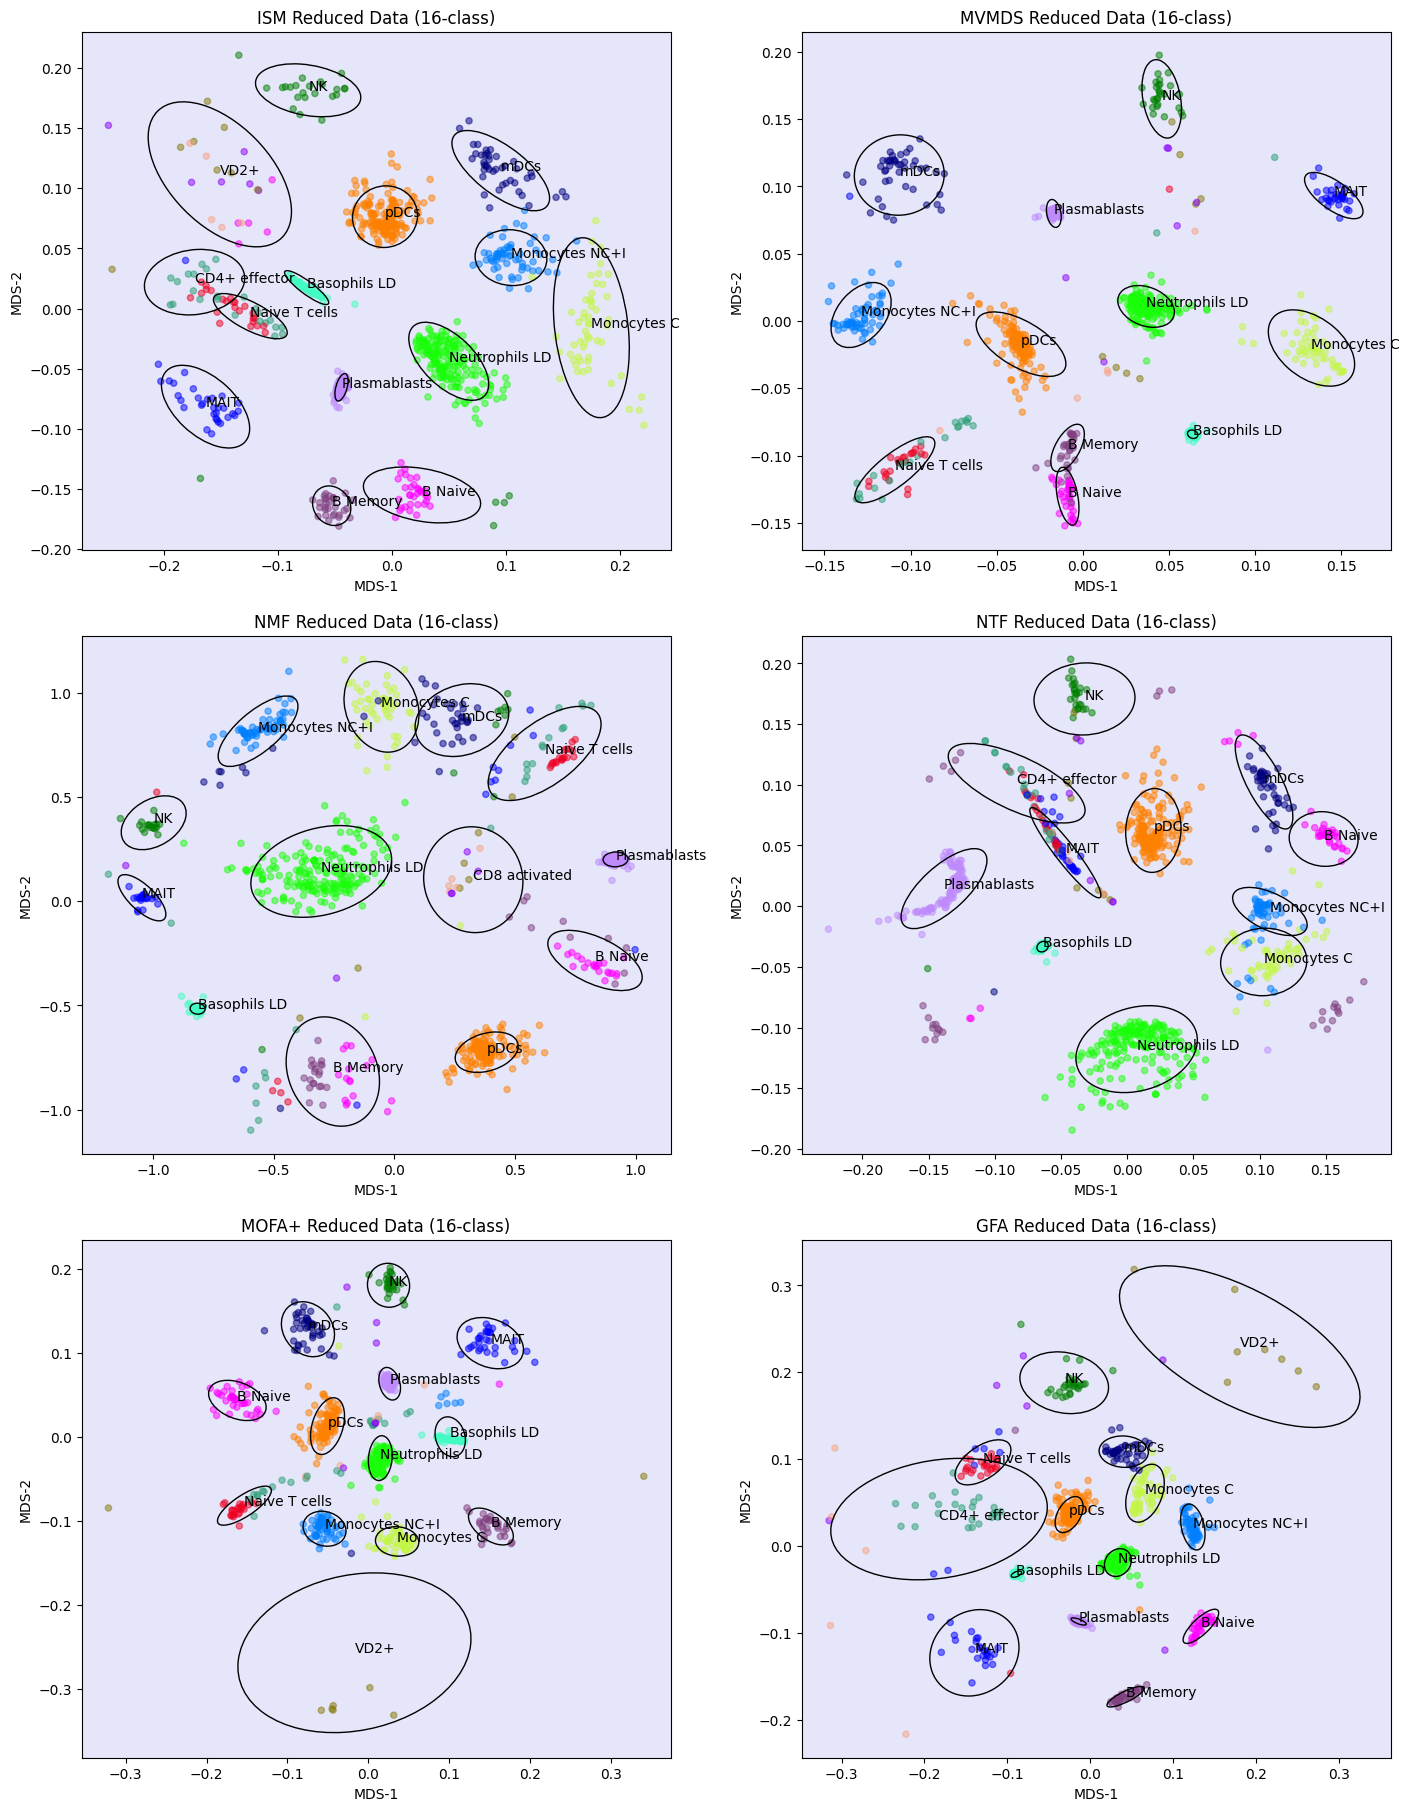

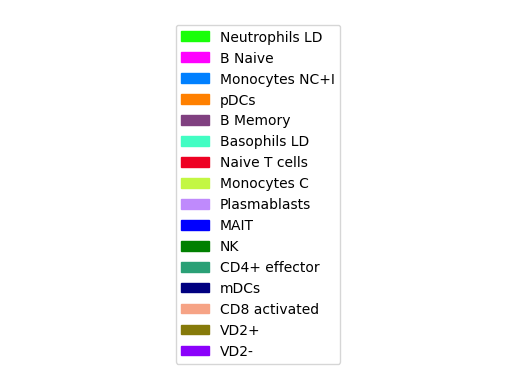

In [11]:
palette = distinctipy.get_colors(16)
cmap = ListedColormap(palette)

patches = []
for code in range(16):
    patches.append(mpatches.Patch(color=palette[code], label=list_cell_types[code]))
    
# Define a function to plot the confidence ellipse
def confidence_ellipse(x, y, cell_label, ax, n_std=2, facecolor='none', **kwargs):
    # Create a plot of the covariance confidence ellipse of `x` and `y`
    # Adapted from [1](https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html)
    
    # Calculate the covariance matrix and the Pearson correlation coefficient
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Use a special case to obtain the eigenvalues of the covariance matrix
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    
    # Create the ellipse object
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    
    # Scale and translate the ellipse according to the mean and standard deviation of the data
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    
    # Annotate centroid
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    ax.annotate(cell_label, xy=(x_mean, y_mean))

    # Add the ellipse to the axes
    ax.add_patch(ellipse)
    return x_mean, y_mean

# define a function to plot scatter with clusters and confidence ellipses
def plot_scatter(x, y, title=None, k=None, ax=None, list_cell_codes=None, skip_ellipse=[], face_color='lavender', n_std=2, **kwargs):
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(np.c_[x, y])
    # Get the cluster labels and centroids
    labels = kmeans.labels_  # Get cluster labels
    labels_matched = np.empty_like(labels)
    unique_labels = np.unique(labels)
    truth_label = np.zeros(len(unique_labels))

    # For each cluster label...
    for l in unique_labels:
        # ...find and assign the best-matching truth label
        match_nums = [np.sum((labels==l)*(list_cell_codes==t)) for t in np.unique(list_cell_codes)]
        truth_label[l] = np.unique(list_cell_codes)[np.argmax(match_nums)]
        labels_matched[labels==l] = truth_label[l]

    ax.scatter(x, y, c=list_cell_codes[:n_marker_genes], cmap=cmap, alpha=0.5, s=20)
    ax.set_title(title)
    ax.set_xlabel("MDS-1")
    ax.set_ylabel("MDS-2")
    ax.set_facecolor(face_color)

    p1 = np.zeros(k)
    p2 = np.zeros(k)
    unique_labels_matched = np.unique(labels_matched)
    xy_mean = np.zeros((len(unique_labels),2))    
    mean_intra_distance = np.zeros(len(unique_labels))
    mean_inter_distance = np.zeros(len(unique_labels))
    flag = np.zeros(len(unique_labels))

    for l in unique_labels_matched:
        indices = np.where(truth_label == l)[0]
        if indices.shape[0] > 1:
            # calculate mean distance inter-clusters pointing to same class
            xy_mean2 = np.zeros((indices.shape[0],2))
            for l2 in range(len(indices)):
                xy_mean2[l2,0] = np.mean(x[labels == indices[l2]])
                xy_mean2[l2,1] = np.mean(y[labels == indices[l2]])
                xy_intra = np.column_stack((x[labels == indices[l2]], y[labels == indices[l2]]))
                D = distance_matrix(xy_intra, xy_intra)
                mean_intra_distance[l] += np.mean(D[D>0])
                    
            D = distance_matrix(xy_mean2, xy_mean2)
            mean_inter_distance[l] = np.mean(D[D>0])
            if mean_inter_distance[l] / mean_intra_distance[l] > 1:
                flag[l] = 1

    
    n_matched_cell_types = 0
    
    for l in np.unique(labels_matched):
        if not flag[l]:
            p1[l] = np.sum(labels_matched[labels_matched==l] == list_cell_codes[labels_matched==l])
            p2[l] = p1[l] / np.sum(list_cell_codes == l)
            p1[l] /=  np.sum(labels_matched == l)
            # if p1[l] > .5 and p2[l] > .5:
            if p2[l] > .5:
                n_matched_cell_types += 1
                if l==14 and n_std==.8:
                    xy_mean[l,0], xy_mean[l,1] = confidence_ellipse(x[labels_matched == l], y[labels_matched == l], list_cell_types[l], ax, n_std=n_std, edgecolor='black')
                else:
                    xy_mean[l,0], xy_mean[l,1] = confidence_ellipse(x[labels_matched == l], y[labels_matched == l], list_cell_types[l], ax, edgecolor='black')
            else:
                p1[l] = 0
                p2[l] = 0
        else:
            xy_mean[l,0] = 0
            xy_mean[l,1] = 0
    
    print(n_matched_cell_types, round(np.sum(p1*p2),2))
    print(round(rand_score(labels_matched, list_cell_codes),4))  # Output: 1.0

fig, ax = plt.subplots(3, 2, figsize=(14, 18), constrained_layout=True)

face_color = 'lavender'
k=16

plot_scatter(w4_ism_mds[:, 0], w4_ism_mds[:, 1], title="ISM Reduced Data (16-class)", k=k, ax=ax[0,0], list_cell_codes=list_cell_codes)
plot_scatter(Xs_mvmds_reduced_mds[:, 0], Xs_mvmds_reduced_mds[:, 1], title="MVMDS Reduced Data (16-class)", k=k, ax=ax[0,1], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(w4_nmf_mds[:, 0], w4_nmf_mds[:, 1], title="NMF Reduced Data (16-class)", k=k, ax=ax[1,0], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(w4_ntf_mds[:, 0], w4_ntf_mds[:, 1], title="NTF Reduced Data (16-class)", k=k, ax=ax[1,1], list_cell_codes=list_cell_codes, skip_ellipse=[])
plot_scatter(w4_mofa_mds[:, 0], w4_mofa_mds[:, 1], title="MOFA+ Reduced Data (16-class)", k=k, ax=ax[2,0], list_cell_codes=list_cell_codes, skip_ellipse=[], n_std=.8)
plot_scatter(w4_gfa_mds[:, 0], w4_gfa_mds[:, 1], title="GFA Reduced Data (16-class)", k=k, ax=ax[2,1], list_cell_codes=list_cell_codes, skip_ellipse=[])

plt.show

# Add the legend to a new figure
fig2, ax2 = plt.subplots()
ax2.legend(handles=patches, loc='center')
plt.gca().set_axis_off()
ax2.set_facecolor(face_color)
plt.show